In [1]:
import csv
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from PIL import Image
from tensorflow import keras
from glob import glob
import pandas as pd
import imutils
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import argparse
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

# 2차로 추가로 받은 데이터입니다

## imp = Rp

## imp > 10000 인 데이터 삭제

# Data Pre-processing

In [2]:
#각 엑셀 파일에서 Rp, Rs 값 추출

file_names_list = []
imp_list = []
dir = "data_files/0713/excel_files"

for file in os.listdir(dir):
    file_name = dir + "/" + file
    f = open(file_name,'r', encoding='UTF8')
    rdr = list(csv.reader(f))
    Rp = round(float(rdr[120][8])/5, 3)
    #Rs = round(float(rdr[120][10])/5, 3)
    imp = Rp
    if imp > 10000:
        continue
    file_names_list.append(file.split("_")[1].replace(" ", "").replace(",", "").replace(".", ""))
    imp_list.append(imp)
    
    print("file : ", file, "    imp : ", imp)
    
    f.close()


file :  Generic C-f [(1) _30, 1, no.6_; 7_3_2023 1_46_05 PM].csv     imp :  5231.247
file :  Generic C-f [(1) _40, 1, no.5_; 7_3_2023 1_26_50 PM].csv     imp :  3377.876
file :  Generic C-f [(10) _40, 3, no.5_; 7_3_2023 1_30_34 PM].csv     imp :  8857.827
file :  Generic C-f [(10) _70, 3, no.5_; 7_3_2023 12_16_08 PM].csv     imp :  1945.563
file :  Generic C-f [(100) _60, 7, no.6_; 7_3_2023 12_51_06 PM].csv     imp :  3908.265
file :  Generic C-f [(104) _60, 9, no.1_; 7_3_2023 12_52_21 PM].csv     imp :  7000.179
file :  Generic C-f [(105) _60, 9, no.2_; 7_3_2023 12_53_00 PM].csv     imp :  4737.585
file :  Generic C-f [(106) _60, 9, no.3_; 7_3_2023 12_53_29 PM].csv     imp :  3954.343
file :  Generic C-f [(11) _70, 3, no.6_; 7_3_2023 12_16_39 PM].csv     imp :  1859.064
file :  Generic C-f [(110) _60, 9, no.4_; 7_3_2023 12_54_13 PM].csv     imp :  4746.952
file :  Generic C-f [(111) _60, 9, no.5_; 7_3_2023 12_54_41 PM].csv     imp :  4164.22
file :  Generic C-f [(112) _60, 9, no.6_; 7

In [3]:
# save cropped images with impedance values on their file names

In [5]:
ground_dir = "data_files/0713/"
image_dir = ground_dir + "images"
make_dir = ground_dir + "processed_images_Rp"
os.makedirs(make_dir)

count = 0

for file in os.listdir(image_dir):
    
    original_image_name = file[:-4].replace(" ", "").replace(",", "").replace(".", "")
    
    try:
        imp_index = file_names_list.index(original_image_name)
    except ValueError:
        print("cannot find excel file for : " + file)
        continue
     
    new_image_name = imp_list[imp_index]
    image = load_img(image_dir + "/" + file)
    cropped_image = image.crop((0,448,2560,1472))
    cropped_image.save(make_dir + "/" + str(new_image_name) + ".jpg")
    
    count += 1
    
print("saved " + str(count) + " images")

cannot find excel file for : 30, 3, no.1.jpg
cannot find excel file for : 30, 3, no.2.jpg
cannot find excel file for : 30, 3, no.3.jpg
cannot find excel file for : 30, 3, no.4.jpg
cannot find excel file for : 30, 3, no.5.jpg
cannot find excel file for : 30, 3, no.6.jpg
cannot find excel file for : 30, 3, no.7.jpg
cannot find excel file for : 30, 5, no.1.jpg
cannot find excel file for : 30, 5, no.2.jpg
cannot find excel file for : 30, 5, no.3.jpg
cannot find excel file for : 30, 5, no.4.jpg
cannot find excel file for : 30, 5, no.5.jpg
cannot find excel file for : 30, 5, no.6.jpg
cannot find excel file for : 30, 5, no.7.jpg
cannot find excel file for : 30, 7, no.1.jpg
cannot find excel file for : 30, 7, no.2.jpg
cannot find excel file for : 30, 7, no.3.jpg
cannot find excel file for : 30, 7, no.4.jpg
cannot find excel file for : 40, 3, no.3.jpg
cannot find excel file for : 40, 3, no.6.jpg
cannot find excel file for : 40, 3, no.7.jpg
cannot find excel file for : 40, 5, no.1.jpg
cannot fin

# CNN Training

In [6]:
# 학습용 이미지 쪼개기
# 저장된 이미지는 (1024*2560)

image_width = 256
image_height = 1024
rows = 1
columns = 10

X = []
Y = []

for file_name in os.listdir(make_dir):
    if file_name != '.DS_Store':
        image = Image.open(make_dir+"/"+file_name).convert("L")
        for j in range(rows):

            for i in range(columns):
                cropped = image.crop((i*image_width,j*image_height,(i+1)*image_width,(j+1)*image_height))
                cropped = np.array(cropped)
                X.append(cropped)
                Y.append(int(float(file_name[:-4])))

In [7]:
X = np.array(X)/255.0
Y = np.array(Y)
print(X.shape, Y.shape)

(1080, 1024, 256) (1080,)


In [8]:
standard_scaler_y = StandardScaler()
reshape_y = Y.reshape(-1,1)
reshape_y = standard_scaler_y.fit_transform(reshape_y)

In [9]:
test_size = 0.2
shuffle = True
random_state = 42

train_x, test_x, train_y, test_y = train_test_split(X, reshape_y, test_size=test_size, shuffle=shuffle, random_state=random_state)

In [10]:
# callback
patience=10
early_stopping_cb = EarlyStopping(patience=patience, restore_best_weights=True, monitor='val_loss')

In [11]:
train_x_cnn = train_x[..., np.newaxis]
test_x_cnn = test_x[..., np.newaxis]

In [12]:
train_x_cnn.shape

(864, 1024, 256, 1)

In [13]:
train_y.shape

(864, 1)

In [14]:

# sequential model
cnn_model = keras.models.Sequential()

# input and convolutional layer
cnn_model.add(keras.layers.Conv2D(32, 7, activation='relu', padding='same',
                                  input_shape=[1024, 256, 1]))
# pooling layer
cnn_model.add(keras.layers.MaxPooling2D(2))

# convolutional layers and pooling layer
cnn_model.add(keras.layers.Conv2D(64, 3, activation='relu', padding='same'))
cnn_model.add(keras.layers.Conv2D(64, 3, activation='relu', padding='same'))
cnn_model.add(keras.layers.MaxPooling2D(2))

# convolutional layers and pooling layer
cnn_model.add(keras.layers.Conv2D(128, 3, activation='relu', padding='same'))
cnn_model.add(keras.layers.Conv2D(128, 3, activation='relu', padding='same'))
cnn_model.add(keras.layers.MaxPooling2D(2))

# flatten layer
cnn_model.add(keras.layers.Flatten())

# dense layers
cnn_model.add(keras.layers.Dense(64, activation='relu'))
cnn_model.add(keras.layers.Dense(32, activation='relu'))

# output layer
cnn_model.add(keras.layers.Dense(1))

# model complie
cnn_model.compile(optimizer='adam',loss='mse')

In [15]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1024, 256, 32)     1600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 512, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 128, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 512, 128, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 256, 64, 64)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 64, 128)      7

In [ ]:
path_directory = make_dir + ".h5"
istrue = os.path.exists(path_directory)

if not istrue:
    history = cnn_model.fit(train_x_cnn, train_y, callbacks=[early_stopping_cb],
                            epochs=100, validation_split=0.2)
    cnn_model.save(path_directory)
    print("model is saved")
else:
    cnn_model = keras.models.load_model(path_directory)
    print("model is loaded")

Epoch 1/100
22/22 [==============================] - 13s 354ms/step - loss: 1.7448 - val_loss: 0.9618
Epoch 2/100
22/22 [==============================] - 4s 189ms/step - loss: 0.9759 - val_loss: 0.9539
Epoch 3/100
22/22 [==============================] - 4s 187ms/step - loss: 0.8636 - val_loss: 0.5127
Epoch 4/100
22/22 [==============================] - 4s 184ms/step - loss: 0.7914 - val_loss: 0.7279
Epoch 5/100
22/22 [==============================] - 4s 182ms/step - loss: 0.5848 - val_loss: 0.9404
Epoch 6/100
22/22 [==============================] - 4s 186ms/step - loss: 0.5740 - val_loss: 0.3841
Epoch 7/100
22/22 [==============================] - 4s 185ms/step - loss: 0.3824 - val_loss: 0.3497
Epoch 8/100
22/22 [==============================] - 4s 184ms/step - loss: 0.2969 - val_loss: 0.2794
Epoch 9/100
22/22 [==============================] - 4s 185ms/step - loss: 0.2599 - val_loss: 0.2559
Epoch 10/100
22/22 [==============================] - 4s 185ms/step - loss: 0.2587 - val_l

# Results

In [53]:
print(cnn_model.evaluate(train_x_cnn, train_y))


27/27 [==============================] - 1s 52ms/step - loss: 0.8129
0.8128934502601624


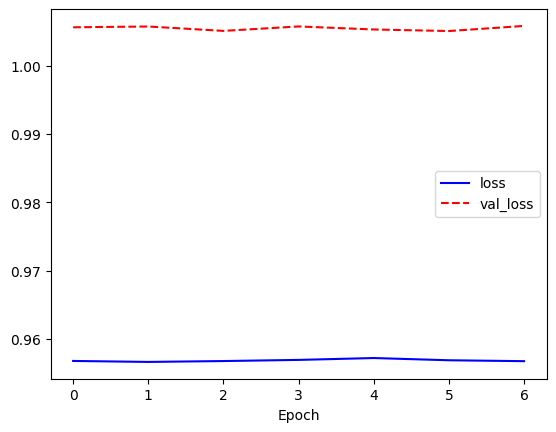

In [54]:
plt.plot(history.history['loss'][5:], 'b-', label='loss')
plt.plot(history.history['val_loss'][5:], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

7/7 [==============================] - 2s 246ms/step


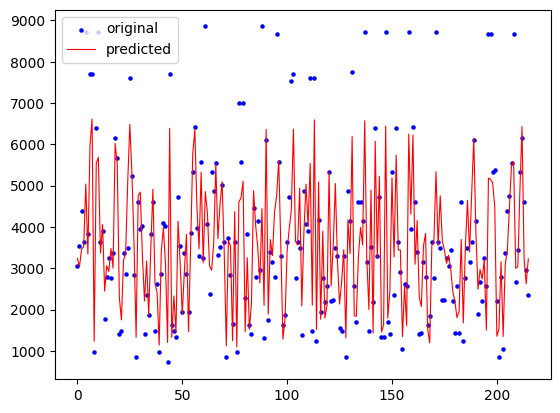

In [36]:
pred = cnn_model.predict(test_x)
inv_test_y = standard_scaler_y.inverse_transform(test_y)
inv_pred = standard_scaler_y.inverse_transform(pred)

x_ax = range(len(inv_pred))
plt.scatter(x_ax, inv_test_y, s=5, color="blue", label="original")
plt.plot(x_ax, inv_pred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

In [37]:
print("RMSE: %.4f" % mean_squared_error(inv_test_y, inv_pred)**(1/2))

RMSE: 1094.5620
